In [1]:
import pandas as pd
import optuna
import optunahub
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from optuna.samplers import TPESampler

/home/saavajuu/anaconda3/envs/iml_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== Summary Statistics ===
                 MW    NumOfAtoms        NumOfC        NumOfO        NumOfN  \
count  26637.000000  26637.000000  26637.000000  26637.000000  26637.000000   
mean     264.638341     26.251567      6.862409      9.937042      1.063558   
std       49.618151      5.229818      1.453679      2.485167      0.710745   
min       30.010565      4.000000      1.000000      0.000000      0.000000   
25%      233.017166     23.000000      6.000000      8.000000      1.000000   
50%      266.986260     26.000000      7.000000     10.000000      1.000000   
75%      299.012475     30.000000      7.000000     12.000000      2.000000   
max      386.044503     41.000000     10.000000     17.000000      2.000000   

       NumHBondDonors     NumOfConf  NumOfConfUsed  C=C (non-aromatic)  \
count    26637.000000  26637.000000   26637.000000        26637.000000   
mean         2.201637    229.856778      25.700417            0.091001   
std          1.021029    203.234312    

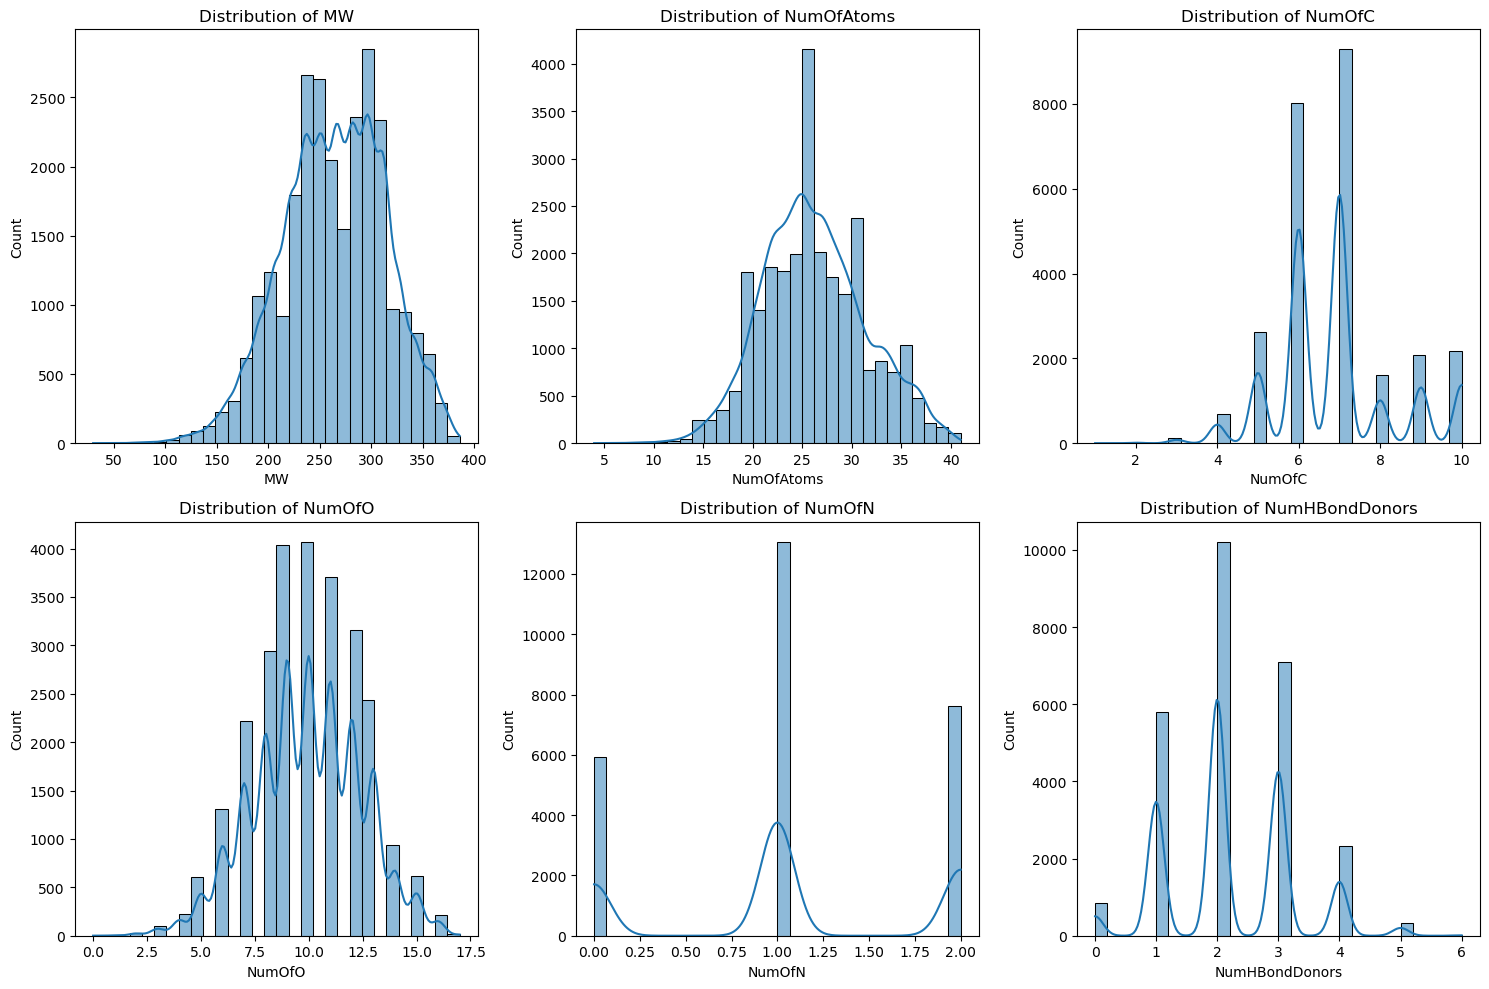


=== Feature Correlations ===
                                    MW  NumOfAtoms    NumOfC    NumOfO  \
MW                            1.000000    0.707009  0.373403  0.880358   
NumOfAtoms                    0.707009    1.000000  0.838402  0.318683   
NumOfC                        0.373403    0.838402  1.000000 -0.081940   
NumOfO                        0.880358    0.318683 -0.081940  1.000000   
NumOfN                        0.772575    0.491902  0.127904  0.656750   
NumHBondDonors                0.074792   -0.008565 -0.171699  0.243910   
NumOfConf                     0.387003    0.452522  0.257684  0.319731   
NumOfConfUsed                 0.292604    0.393580  0.289234  0.140742   
C=C (non-aromatic)           -0.156715   -0.214209 -0.062667 -0.119401   
C=C-C=O in non-aromatic ring -0.077751   -0.089377 -0.007453 -0.069275   
hydroxyl (alkyl)              0.037675   -0.036006 -0.123526  0.124449   
aldehyde                     -0.109437   -0.180620 -0.072839 -0.054361   
ketone  

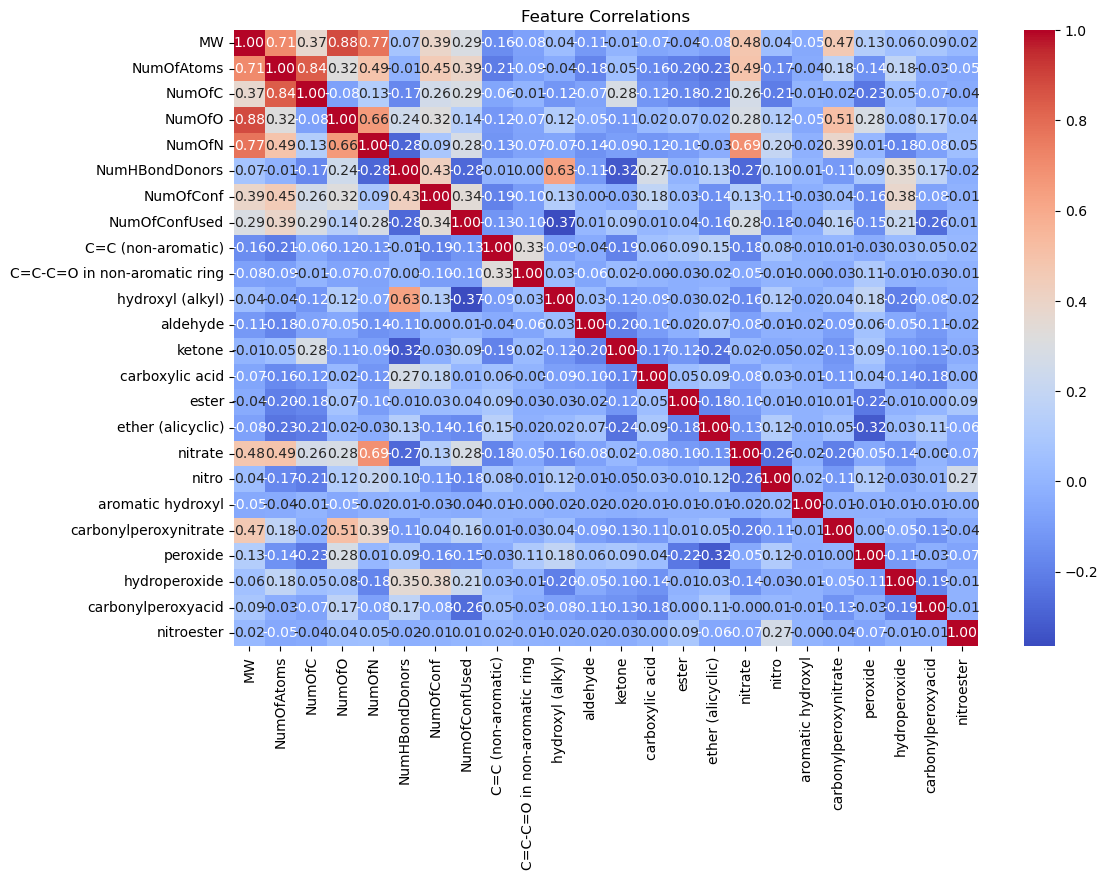

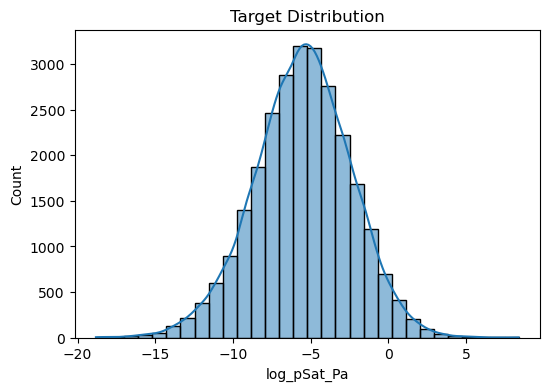

Target Skewness: -0.14
Target Kurtosis: 0.24


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# Load Data
data = pd.read_csv("../Data/train.csv")
features = data.drop(columns=["log_pSat_Pa", "ID", "parentspecies"])
target = data["log_pSat_Pa"]

# Summary Statistics
print("=== Summary Statistics ===")
print(features.describe())

# Skewness and Kurtosis
print("\n=== Skewness and Kurtosis ===")
skewness = features.apply(lambda x: skew(x.dropna()))
kurt = features.apply(lambda x: kurtosis(x.dropna()))
print(pd.DataFrame({"Skewness": skewness, "Kurtosis": kurt}))

# Plot Distributions of Features
def plot_distributions(features, num_plots=6):
    """Plot distributions of numerical features."""
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(features.columns[:num_plots], 1):
        plt.subplot(2, 3, i)
        sns.histplot(features[col].dropna(), kde=True, bins=30)
        plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

plot_distributions(features)

# Correlations
print("\n=== Feature Correlations ===")
correlations = features.corr()
print(correlations)

# Plot Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()

# Target Analysis
plt.figure(figsize=(6, 4))
sns.histplot(target, kde=True, bins=30)
plt.title("Target Distribution")
plt.show()

print(f"Target Skewness: {skew(target):.2f}")
print(f"Target Kurtosis: {kurtosis(target):.2f}")


In [ ]:
import numpy as np

def transform_features(df):
    """
    Apply transformations to the input DataFrame based on observed distributions.
    """
    # Log transformation for MW
    if 'MW' in df.columns:
        df['MW_log'] = np.log1p(df['MW'])  # log(1+x) to avoid log(0)
        df.drop(columns=['MW'], inplace=True)
    
    if "NumOfConf" in df.columns:
        df["NumOfConf_log"] = np.log1p(df["NumOfConf"])
        df.drop(columns=["NumOfConf"], inplace=True)
    
    # Square root transformation for NumOfAtoms
    if 'NumOfAtoms' in df.columns:
        df['NumOfAtoms_sqrt'] = np.sqrt(df['NumOfAtoms'])
        df.drop(columns=['NumOfAtoms'], inplace=True)
    
    # Bin NumOfN into categories
    if 'NumOfN' in df.columns:
        bins = [-1, 0, 1, 2]  # Define bin edges
        labels = ['0', '1', '2']
        df['NumOfN_binned'] = pd.cut(df['NumOfN'], bins=bins, labels=labels, include_lowest=True)
        df.drop(columns=['NumOfN'], inplace=True)
    
    # No transformation for NumOfC, NumOfO, and NumHBondDonors (can explore further if needed)
    
    return df

# Example usage
train_transformed = transform_features(train.copy())

# fit lgmb
model = lgb.LGBMRegressor(
    objective="regression",
    metric="rmse",
    boosting_type="gbdt",
    n_estimators=1000,
    learning_rate=0.01,
    num_leaves=31,
    max_depth=7,
    random_state=42,
    n_jobs=-1,
)

# Fit the model
model.fit(train_transformed, target)

# Predict on the training set
train_predictions = model.predict(train_transformed)


# Evaluate the model
rmse = mean_squared_error(target, train_predictions, squared=False)
mae = mean_absolute_error(target, train_predictions)
r2 = r2_score(target, train_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# load and process test data
test = pd.read_csv("../Data/test.csv")
test_ids = test["ID"]
test = test.drop(columns=["ID", "parentspecies"])

test_transformed = transform_features(test.copy())

# Predict on the test set
test_predictions = model.predict(test_transformed)

# Save predictions to a CSV file
output = pd.DataFrame({"ID": test_ids, "TARGET": test_predictions})
output.to_csv("back_to_beginning.csv", index=False)





[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1177
[LightGBM] [Info] Number of data points in the train set: 26637, number of used features: 29
[LightGBM] [Info] Start training from score -5.516747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/home/saavajuu/anaconda3/envs/iml_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [2]:
# To avoid data leakage implementation that can be used in the cross-validation loop

def feature_engineering5(df):

    df['lg_NumOfConf'] = np.log1p(df['NumOfConf'])
    df['sqrt_NumOfConfUsed'] = np.sqrt(df['NumOfConfUsed'])
    df['lg_NumHBondDonors'] = np.log1p(df['NumHBondDonors'])
    df['lg_MW'] = np.log1p(df['MW'])
    
    df['O_C_ratio'] = df['NumOfO'] / df['NumOfC']
    df['H_C_ratio'] = (df['NumOfAtoms'] - df['NumOfC'] - df['NumOfO'] - df['NumOfN']) / df['NumOfC']
    
    df['mw_donor_prod'] = df['MW'] * df['NumHBondDonors']
    df['C_O_prod'] = df['NumOfC'] * df['NumOfO']
    
    df['HydroBGroup'] = df['hydroxyl (alkyl)'] + df['carboxylic acid'] + df['hydroperoxide']
    df['OxyFGroup'] = df['hydroxyl (alkyl)'] + df['hydroperoxide'] + df['peroxide'] + df['ketone'] + df['carboxylic acid']

    df['groupSpecial'] = df['HydroBGroup'] * df['OxyFGroup']
    df['groupSpecial2'] = df['O_C_ratio'] * df['OxyFGroup']
    

    df['Conf_to_ConfUsed_ratio_lg'] = df['lg_NumOfConf'] / df['sqrt_NumOfConfUsed']
    df['Special2_log'] = df['lg_NumOfConf'] * df['lg_NumHBondDonors']
    df['C_to_MW_ratio'] = df['NumOfC'] / df['MW']
    df['O_to_MW_ratio'] = df['NumOfO'] / df['MW']
    df['N_to_MW_ratio'] = df['NumOfN'] / df['MW']
    df['total_groups_mean'] = df[['hydroxyl (alkyl)', 'ketone', 'aldehyde', 'carboxylic acid', 'ester', 'ether (alicyclic)', 'nitrate', 'nitro', 'aromatic hydroxyl', 'carbonylperoxynitrate', 'peroxide', 'hydroperoxide', 'carbonylperoxyacid', 'nitroester']].mean(axis=1)
    df['totalgroupsAtoms'] = df['total_groups_mean'] * df['NumOfAtoms']
    df['totalgroupsMW'] = df['total_groups_mean'] * df['MW']
    
    df['Special420'] = df['total_groups_mean'] * df['NumOfC']
    df['Special421'] = df['total_groups_mean'] * df['NumOfO']
    df['Special422'] = df['total_groups_mean'] * df['NumOfN']
    df['Special423'] = df['NumHBondDonors'] * df['total_groups_mean']
    df['Special424'] = df['NumHBondDonors'] * df['NumOfAtoms']
    df['extraspecial'] = df['NumHBondDonors'] * df['MW']
    
    return df


def scale_features(train_df, val_df):
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
    val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
    return train_df, val_df

In [6]:
db_path = "sqlite:///../Data/optuna.db"
study_name = "clean_optuna_studies_v1"

# Create a new study or load an existing one
study = optuna.create_study(study_name=study_name,
                            storage=db_path,
                            load_if_exists=True,
                            direction="minimize",
                            sampler=TPESampler(seed=17)
                            #sampler=optunahub.load_module("samplers/auto_sampler").AutoSampler()
                            )

# Load the data
train = pd.read_csv("../Data/train.csv")
train= pd.get_dummies(train, columns=['parentspecies'], drop_first=True)

# Split the data
train_x = train.drop(columns=["log_pSat_Pa", "ID"])
train_y = train["log_pSat_Pa"]


[I 2024-11-30 18:54:04,404] Using an existing study with name 'clean_optuna_studies_v1' instead of creating a new one.


In [ ]:
def improved_objective_func(trial):
    params = {
        "n_estimators": trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.25, 0.95),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.9, step=0.1),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 300),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        "max_depth": trial.suggest_int('max_depth', -1, 30),
        "min_gain_to_split": trial.suggest_int('min_gain_to_split', 0, 15),
        "lambda_l1": trial.suggest_float('lambda_l1', 0.0, 10),
        "lambda_l2": trial.suggest_float('lambda_l2', 0.0, 10),
        "bagging_fraction": trial.suggest_float('bagging_fraction', 0.2, 1),
        "max_bin": trial.suggest_int('max_bin', 100, 500),
        "bagging_freq": trial.suggest_int('bagging_freq', 1, 10),
        "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 1, 200),
        "cat_smooth": trial.suggest_int('cat_smooth', 1, 100),
        'random_state': 7
    }
    
    model = lgb.LGBMRegressor(**params, verbose=-1)
    #bins = pd.qcut(train_y, q=10, duplicates="drop") 
    kf = KFold(n_splits=3, shuffle=True, random_state=7)
    mae_scores = []
    
    for train_index, val_index in kf.split(train_x):
        X_train, X_val = train_x.loc[train_index], train_x.loc[val_index]
        y_train, y_val = train_y.loc[train_index], train_y.loc[val_index]
        
        X_train = feature_engineering5(X_train)
        X_val = feature_engineering5(X_val)
        
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)])
        
        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        mae_scores.append(mae)
    
    return np.mean(mae_scores)

# Create a study and optimize
study.optimize(improved_objective_func, n_trials=500)
print(f"Best trial: {study.best_trial.params}")

[W 2024-11-30 18:53:07,987] Trial 1 failed with parameters: {'n_estimators': 687, 'learning_rate': 0.030843268446461337, 'subsample': 0.6682592772673357, 'subsample_freq': 5, 'feature_fraction': 0.4, 'min_child_samples': 51, 'num_leaves': 73, 'max_depth': 5, 'min_gain_to_split': 12, 'lambda_l1': 4.184843853458769, 'lambda_l2': 1.4390392077532788, 'bagging_fraction': 0.49054401665240627, 'max_bin': 122, 'bagging_freq': 8, 'min_data_in_leaf': 30} because of the following error: TypeError("cv() got an unexpected keyword argument 'objective'").
Traceback (most recent call last):
  File "/home/saavajuu/anaconda3/envs/iml_env/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_475975/2740047814.py", line 34, in improved_objective_func_cv
    cv_results = lgb.cv(
TypeError: cv() got an unexpected keyword argument 'objective'
[W 2024-11-30 18:53:07,988] Trial 1 failed with value None.


TypeError: cv() got an unexpected keyword argument 'objective'